# Introduction
In the next few steps, I will try to build machine learning models to predict defaults using Python. I could make all of my work in one open source language. I decided to move to Python for two reasons. I am willing to show that I feel comfortable using both R and Python. Second of all, I believe Python is better suited for moving models to production. R is superior when it comes to analysis of data. For example, it was way easier to implement WOE transformation in R, in Python I would probably need to categorize variables using decision trees by myself and than calculate WOE. From my own point of view, it is easier to implement pipelines on production using Python. 

# Modelling
During pre-processing and analysis of data, I have noticed that by using this dataset, it will be hard to build a good predictive model. This dataset clearly was not build for predictive modeling purpose. Most of the variables are "from the future". Other have too many missing values and the rest of variables, which I had to drop are unstable. If variables were calculated for the moment of application there would be enough information to build a model. In credit scoring and in every other data science project it is crucial to prepare data properly. Otherwise, there is no point in modeling. As mentioned earlier, I want to make this process similar to real-world problem and in real life, I cannot use any of the variables, which I dropped.

During my anlysis, I came to a conclusion that I did not have many variables to choose from and those which I could use did not have big Information Value. It means that before trying to build the first model I can tell that using those it will be hard to distinguish good applications from bad ones.

I will build those models, because it is predictive modeling test and also because it is supposed to be close to a real life problem. In real life, I would probably need to show customer that it is impossible to build a quality model on data he provided and ask him to build a dataset from the beginning.

In [1]:
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn import preprocessing, linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, f1_score, recall_score, precision_score

from xgboost import XGBRegressor, XGBClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import backend as K

C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Anaconda3\lib\site-packages\requests\__init__.py:80: RequestsDependencyWarning: urllib3 (1.22) or chardet (2.3.0) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
def prob_corr(prob_1,p_apriori_train,p_sample_train):
    prob_0 = 1- prob_1
    p_apriori_1 = p_apriori_train
    p_sample_1 = p_sample_train

    beta = p_sample_1/p_apriori_1
    P1 = beta*prob_1/((beta-1)*prob_1+1)
    return P1

I need to calculate posterior probabilities of machine learning models, which I build on sample data. I'm using formula from this paper: https://www3.nd.edu/~rjohns15/content/papers/ssci2015_calibrating.pdf. 

Functions, which I use to evaluate models.

In [3]:
def gini(actual, pred, cmpcol = 0, sortcol = 1):
     assert( len(actual) == len(pred) )
     all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
     all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
     totalLosses = all[:,0].sum()
     giniSum = all[:,0].cumsum().sum() / totalLosses
 
     giniSum -= (len(actual) + 1) / 2.
     return giniSum / len(actual)

To the evaulate quality of the model, I will be using Gini statistic. It's common practice to use Gini in credit scoring. 

In [4]:
def model_score(probs,y_val,data="train"):
    roc_auc = []
    accuracies = []
    f1 = []
    xs = []
    precision=[]
    gini_l = []
    if data in ("train","valid"):
        probs =prob_corr(probs,p_apriori_train,p_sample_train)
    for x in range(5,95,5):
        xs.append(x/100)
        cutoff = x/100
        predictions = [int(p>cutoff) for p in probs]
        roc_auc.append(roc_auc_score(y_val, predictions))
        f1.append(f1_score(y_val, predictions))
        precision.append(precision_score(y_val, predictions))
        accuracies.append(accuracy_score(y_val, predictions))
        gini_l.append(gini(y_val, predictions))

    
    plt.plot(xs,f1, label='f1_score',c="blue")
    plt.plot(xs,accuracies, label="accuracy",c="orange")
    plt.plot(xs,precision, label="precision score",c="green")
    plt.plot(xs,gini_l, label="Gini",c="red")
    plt.legend()
    plt.show()
    gini_score = max(gini_l)
    print("Best Gini: %.2f%%" % (gini_score * 100.0))

def roc_curve(probs,y_test,cutoff,train_acc=False):  
    predictions = [int(p>cutoff) for p in probs]
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    gini_score = gini(y_test, predictions)
    fpr, tpr, thresholds = metrics.roc_curve(y_test,probs)
    roc = metrics.auc(fpr, tpr)
    lw=2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title("ROC Curve")

    plt.savefig(r'C:\Users\splasi\Documents\data_science\mckinsey\roc_curve.png')
    plt.show()
    
#     # Compute ROC curve and ROC area for each class
#     fpr = dict()
#     tpr = dict()
#     roc_auc = dict()
#     for i in range(2):
#         fpr[i], tpr[i], _ = metrics.roc_curve(y_test[:, i], y_score[:, i])
#         roc_auc[i] = auc(fpr[i], tpr[i])

#     # Compute micro-average ROC curve and ROC area
#     fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
#     roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

#     plt.figure()
#     lw = 2
#     plt.plot(fpr[2], tpr[2], color='darkorange',
#              lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
#     plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.05])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('Receiver operating characteristic example')
#     plt.legend(loc="lower right")
#     plt.show()
    
    
    print(confusion_matrix(y_test, predictions,labels = [1,0]))
    if train_acc==False:
        print("Accuracy: %.2f%% (test)" % (accuracy * 100.0))
    else:
        print("Accuracy: %.2f%% (test)" % (accuracy * 100.0) + " vs %.2f%% (train)" % (train_acc * 100.0))
    print("Precision: %.2f%%" % (precision * 100.0))
    print("Gini: %.2f%%" % (gini_score * 100.0))

Data loading

In [5]:
data = pd.read_csv(r"C:/Users/splasi/Documents/data_science/mckinsey/train_sample.csv")
test = pd.read_csv(r"C:/Users/splasi/Documents/data_science/mckinsey/final_test.csv")
data_full = pd.read_csv(r"C:/Users/splasi/Documents/data_science/mckinsey/final_train.csv")

p_apriori_train = sum(data_full["default"])/len(data_full)
p_apriori_test = sum(test["default"])/len(test)

print("Percentage of defaults in traing dataset: %.2f%%" % (p_apriori_train * 100.0))
print("Percentage of defaults in out of time dataset: %.2f%%" % (p_apriori_test * 100.0))

p_sample_train = sum(data["default"])/len(data)

print("Percentage of defaults in sampled dataset: %.2f%%" % (p_sample_train * 100.0))

Percentage of defaults in traing dataset: 10.52%
Percentage of defaults in out of time dataset: 4.76%
Percentage of defaults in sampled dataset: 50.00%


In [6]:
X = data.iloc[:,1:]
X = X.drop(["id","default"],axis=1)
y = data["default"]
print(X.shape)

(89146, 24)


In [7]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import Imputer
from statsmodels.stats.outliers_influence import variance_inflation_factor

class ReduceVIF(BaseEstimator, TransformerMixin):
    def __init__(self, thresh=5.0, impute=True, impute_strategy='median'):
        # From looking at documentation, values between 5 and 10 are "okay".
        # Above 10 is too high and so should be removed.
        self.thresh = thresh
        
        # The statsmodel function will fail with NaN values, as such we have to impute them.
        # By default we impute using the median value.
        # This imputation could be taken out and added as part of an sklearn Pipeline.
        if impute:
            self.imputer = Imputer(strategy=impute_strategy)

    def fit(self, X, y=None):
        print('ReduceVIF fit')
        if hasattr(self, 'imputer'):
            self.imputer.fit(X)
        return self

    def transform(self, X, y=None):
        print('ReduceVIF transform')
        columns = X.columns.tolist()
        if hasattr(self, 'imputer'):
            X = pd.DataFrame(self.imputer.transform(X), columns=columns)
        return ReduceVIF.calculate_vif(X, self.thresh)

    @staticmethod
    def calculate_vif(X, thresh=5.0):
        # Taken from https://stats.stackexchange.com/a/253620/53565 and modified
        dropped=True
        while dropped:
            variables = X.columns
            dropped = False
            vif = [variance_inflation_factor(X[variables].values, X.columns.get_loc(var)) for var in X.columns]
            
            max_vif = max(vif)
            if max_vif > thresh:
                maxloc = vif.index(max_vif)
                print(f'Dropping {X.columns[maxloc]} with vif={max_vif}')
                X = X.drop([X.columns.tolist()[maxloc]], axis=1)
                dropped=True
        return X

In [8]:
transformer = ReduceVIF()
X = transformer.fit_transform(X, y)

ReduceVIF fit
ReduceVIF transform
Dropping inq_last_6mths_woe with vif=16.651411151903957
Dropping int_rate_woe with vif=16.555474522975754
Dropping revol_util_woe with vif=13.962301558875824
Dropping grade_woe with vif=9.670184484664288
Dropping st_com_annual_inc_woe with vif=8.167943305518294
Dropping loan_amnt_woe with vif=7.140519543225273
Dropping st_com_total_acc_woe with vif=5.385115348781412


I have created some variables, which can be highly correlated with base variables. Comparison of the loan amount to average loan amount in a state can easily be correlated with loan amount - they can contain similar information about the variance. Therefore I am using Variance Inflation Factor (VIF) to exclude those correlated features. It is possible that even without those new variables there would be multicollinearity.

To drop variables with high VIF value I am using a method which I have found in one Kaggle kernel.

There are 7 variables with high VIF value (>5), therefore 7 variables are being dropped.

In [9]:
X.head()

,installment_woe,annual_inc_woe,total_acc_woe,total_rec_late_fee_woe,st_com_id_woe,st_com_loan_amnt_woe,st_com_int_rate_woe,st_com_installment_woe,st_com_inq_last_6mths_woe,st_com_revol_util_woe,term_woe,emp_length_woe,home_ownership_woe,verification_status_woe,purpose_woe,initial_list_status_woe,state_gr_woe
0,0.073181,0.035142,0.040947,2.029341,0.394573,0.048600,0.116638,0.163722,-0.187796,0.055050,-0.119875,0.056312,0.169742,0.186540,0.050812,0.104172,0.078639
1,0.073181,-0.192229,-0.091602,-0.080517,0.394573,0.048600,-0.920980,0.001024,-0.187796,0.055050,-0.119875,0.056312,-0.148563,-0.046028,-0.238951,0.104172,0.078639
2,-0.147481,0.035142,0.040947,-0.080517,0.394573,-0.090427,-0.391643,-0.141017,-0.187796,0.055050,-0.119875,0.051232,-0.148563,-0.207202,0.319998,0.104172,-0.002796
3,-0.147481,0.229094,-0.057850,-0.080517,0.394573,-0.090427,-0.391643,-0.141017,-0.187796,-0.350107,-0.119875,0.001797,-0.004168,-0.207202,-0.105492,0.104172,0.078639
4,0.062081,-0.192229,0.040947,-0.080517,0.394573,0.094331,-1.531716,0.029965,-0.187796,0.055050,-0.119875,0.051232,-0.148563,-0.046028,-0.238951,-0.186386,-0.002796


In [10]:
print(X.shape)

(89146, 17)


In [11]:
test_size = 0.3
X_train, X_val, y_train, y_val= train_test_split(X, y, test_size=test_size)
X_test = test.iloc[:,1:]
X_test = X_test.drop(["id","default"],axis=1)
y_test = test["default"]
X_test = X_test[X.columns.values]

I'm creating validation dateset to be able to select best model. Final performance will be evaluated on out of time dataset.

# Feature importance

Usually, there is no need to use all variables, besides that using fewer variables prevent overfitting. Thus, I want to determine which variables are the most important. I will be using Lasso Regression and Random Forest for that.

I could also use PCA to reduce dimensions, but in credit scoring usually, it is necessary to be able to interpret features. There is of course the possibility of PCA rotation (e.g. using varimax), which is helpful with interpreting features, but there are not too many features left in the dataset, so dimensionality reduction is not necessary.

# Lasso

In [12]:
lasso = linear_model.LassoCV()
lasso.fit(X_train, y_train)
print(lasso.alpha_)
print(lasso.coef_)

8.898506910846506e-05
[ 0.27841968  0.24313165 -0.07958316  0.16680992  0.19573324  0.07442031
  0.18951511  0.12832372  0.1051531   0.00341827  0.00622731  0.14374725
  0.12715635  0.02703136  0.06461351  0.0222936   0.15271691]


I am using crossvalidation on Lasso model to select best regularization term, which in this case equals 0.0008158. For this alpha there is no need to drop any feature because all coefficients are not 0.

# Random Forest

In [13]:
rf = RandomForestClassifier(
    n_estimators=10,
    max_features=3,
#     verbose=1
)

rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

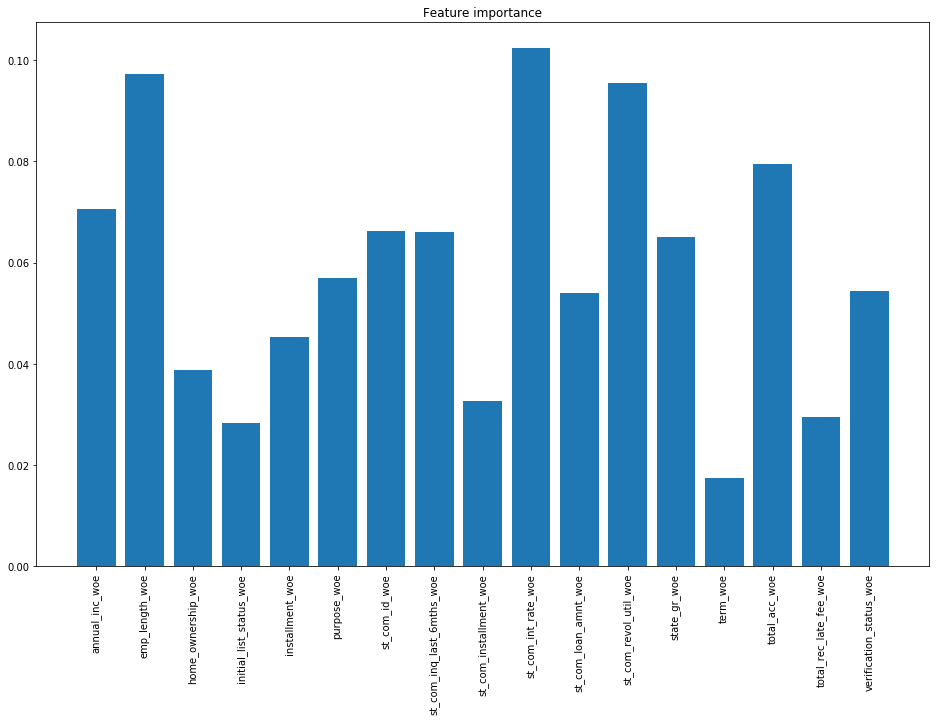

In [14]:
plt.figure(figsize=(16,10))
plt.bar(X_train.columns.tolist(),rf.feature_importances_)
plt.xticks(rotation=90)
plt.title("Feature importance")
plt.show()

There are no huge discrepancies between the importance of features. To determine, which feature is important Mean Decrease Gini statistic is used, which computes average increase of pure splits for each variable. If the feature is important, it means, that it can often split data into "pure" (with one class) subsets. I've decided not to drop any variables. I've tried models with and without not important variables and models on validation where worse without them. I haven't observed overfitting so there is no need in dropping them

In [15]:
# X_train = X_train.loc[:,rf.feature_importances_>0.04]
# X_val = X_val.loc[:,rf.feature_importances_>0.04]
# X_test = X_test.loc[:,rf.feature_importances_>0.04]
# print(X_train.shape)

# Logistic Regression

Logistic regression is probably the most popular machine learning technique in credit scoring. Mainly because it can provide good results and is easily interpretable. What is more, by using Logistic Regression, it is easy to build a scorecard.

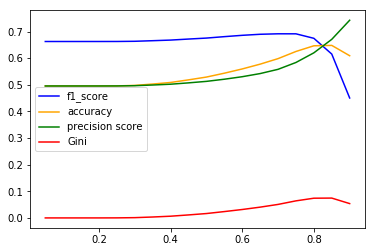

Best Gini: 7.41%


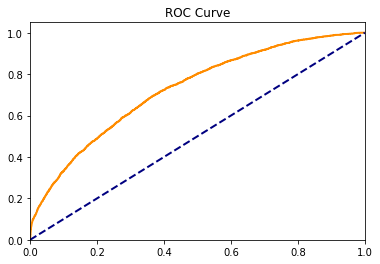

[[  553  2252]
 [ 2244 53828]]
Accuracy: 92.36% (test) vs 65.54% (train)
Precision: 19.77%
Gini: 9.21%


In [16]:
logistic = LogisticRegression()
logistic.fit(X_train,y_train)

train_acc = logistic.score(X_train,y_train)

probs = logistic.predict_proba(X_val)[:,1]
model_score(probs,y_val)
probs = logistic.predict_proba(X_test)[:,1]
roc_curve(probs,y_test,0.7,train_acc)

# Neural Network

Neural Network, unlike Logistic Regression, is not easily interpretable and is not widely used by Banks, but it can change because of libraries like LIME, which can determine why someone's application is rejected. Neural networks, as opposed to Logistic Regression, is not a linear method, which can be crucial. I used WOE transformation with coerced monotonic buckets, so in this case, neural network does not have to be much better than Logistic Regression. 

In [17]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Keras does not have f1_score metric implemented. That's why, I am using this function.

In [18]:
dim = X_train.shape[1]
nn = Sequential()
nn.add(Dense(40, input_dim=dim, activation='relu'))
nn.add(Dropout(0.2))
nn.add(Dense(20, activation='relu'))
nn.add(Dropout(0.2))
nn.add(Dense(1, activation='sigmoid'))


nn.compile(loss='binary_crossentropy',
          optimizer= "adam",
          metrics=[f1])


#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = nn.fit(X_train, y_train
                 ,epochs=150
                 ,batch_size=10000
                 ,verbose=0
                 )

I am using dropout regularization to prevent overfitting, but it is not necessary.

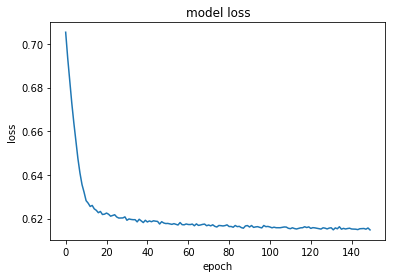

In [19]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

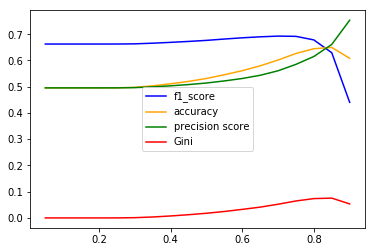

Best Gini: 7.50%


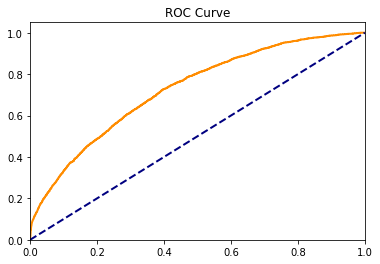

[[  500  2305]
 [ 1853 54219]]
Accuracy: 92.94% (test)
Precision: 21.25%
Gini: 8.65%


In [20]:
probs = nn.predict(X_val)
model_score(probs,y_val)
probs = nn.predict(X_test)
roc_curve(probs,y_test,0.7)

Neural network gives almost same results as Logistic Regression. Gini on a test set is still very small. Too small to consider implementing this model.

# Random Forest


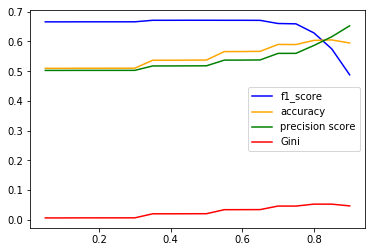

Best Gini: 5.24%


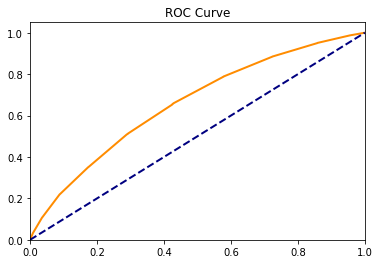

[[  617  2188]
 [ 4969 51103]]
Accuracy: 87.84% (test) vs 97.77% (train)
Precision: 11.05%
Gini: 7.93%


In [21]:
rf = RandomForestClassifier(
    n_estimators=10,
    max_features=3,
#     verbose=1
)
rf.fit(X_train, y_train)

train_acc = rf.score(X_train,y_train)

probs = rf.predict_proba(X_val)[:,1]
model_score(probs,y_val)
probs = rf.predict_proba(X_test)[:,1]
roc_curve(probs,y_test,0.75,train_acc)

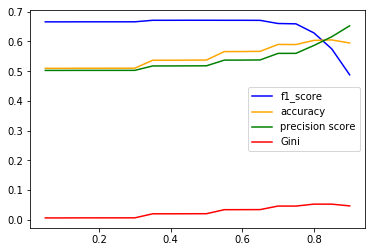

Best Gini: 5.24%


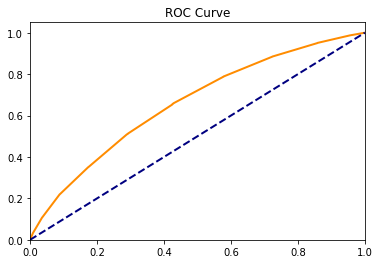

[[  617  2188]
 [ 4969 51103]]
Accuracy: 87.84% (test) vs 97.77% (train)
Precision: 11.05%
Gini: 7.93%


In [22]:
train_acc = rf.score(X_train,y_train)

probs = rf.predict_proba(X_val)[:,1]
model_score(probs,y_val)
probs = rf.predict_proba(X_test)[:,1]
roc_curve(probs,y_test,0.75,train_acc)


predictions = [int(p>0.5) for p in probs]
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
gini_score = gini(y_test, predictions)
fpr, tpr, thresholds = metrics.roc_curve(y_test,predictions)
# print(fpr)
# print(metrics.roc_curve(np.asarray(y_test).ravel(), np.asarray(predictions).ravel()))
# print(predictions)


Random Forest does not give better results either. Comparing accuracy on the test set and train set we can clearly see that model know how to predict non defaults, but it cannnot predict correctly defaults that's why the value of Gini is so small. 

# Naive Bayes

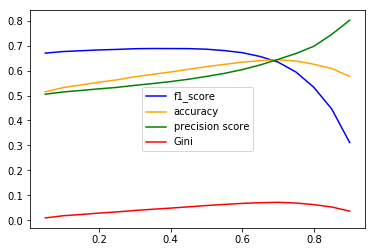

Best Gini: 7.17%


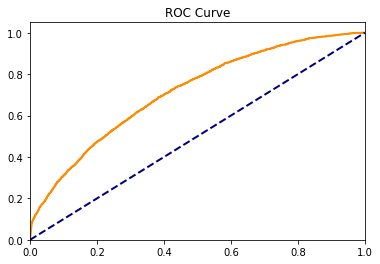

[[  582  2223]
 [ 2854 53218]]
Accuracy: 91.38% (test) vs 61.20% (train)
Precision: 16.94%
Gini: 9.26%


In [23]:
nb = GaussianNB()
nb.fit(X_train, y_train)

train_acc = nb.score(X_train,y_train)

probs = nb.predict_proba(X_val)[:, 1]
model_score(probs,y_val)
probs = nb.predict_proba(X_test)[:, 1]
roc_curve(probs,y_test,0.6, train_acc)

# XGBoost

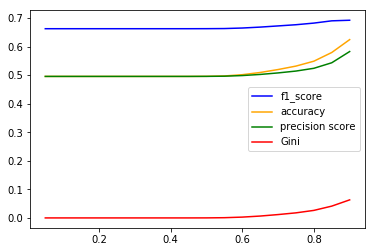

Best Gini: 6.28%


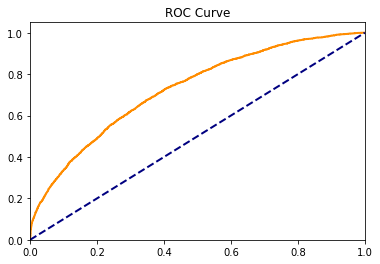

[[ 1328  1477]
 [10484 45588]]
Accuracy: 79.68% (test)
Precision: 11.24%
Gini: 14.78%


In [24]:
from xgboost import  XGBClassifier
xgb = XGBClassifier(objective='binary:logistic',eval_metric = 'auc',scale_pos_weight=3)
xgb.fit(X_train, y_train)

probs = xgb.predict_proba(X_val)[:,1]
model_score(probs,y_val)
probs = xgb.predict_proba(X_test)[:,1]
roc_curve(probs,y_test,0.8)

Gradient boosting method (XGBoost) gives slightly better results with Gini - 14.34%. Unfortunately, this value still is not enough to call it a good model. 

# Ensemble

In last few steps, I have learned that based on data provided none of the models can learn how to predict defaults. My last attempt is to create an ensemble of those models and check if they are able to predict defaults combined. 

In [25]:
models = {
          'nb': {'model':nb,'cutoff':0.6},
          'nn': {'model':nn,'cutoff':0.7},
          'random forest': {'model':rf,'cutoff':0.7},
          'xgb': {'model':xgb,'cutoff':0.8},
          'logistic': {'model':logistic,'cutoff':0.75},
          }
def predict(model_list,X_val,X_test):
    cols = list()
    P_val = np.zeros((y_val.shape[0], len(model_list)))
    P_val = pd.DataFrame(P_val)
    
    P_test = np.zeros((y_test.shape[0], len(model_list)))
    P_test = pd.DataFrame(P_test)

    Y_hat = np.zeros((y_test.shape[0], len(model_list)))
    Y_hat = pd.DataFrame(Y_hat)
    for i, (name, m) in enumerate(models.items()):
        print("%s..." % name, end=" ", flush=False)
        if name in ('nn'):
            probs = m['model'].predict_proba(X_val)
            P_val.iloc[:, i] = probs
            probs = m['model'].predict_proba(X_test)
            P_test.iloc[:, i] = probs
            Y_hat.iloc[:, i] = [int(p>m['cutoff']) for p in probs]
        else:
            probs = m['model'].predict_proba(X_val)[:, 1]
            P_val.iloc[:, i] = probs
            probs = m['model'].predict_proba(X_test)[:, 1]
            P_test.iloc[:, i] = probs
            Y_hat.iloc[:, i] = [int(p>m['cutoff']) for p in probs]
        cols.append(name)
        print("done")

    P_val.columns = cols
    P_test.columns = cols
    Y_hat.columns = cols
    print("Done.\n")
    return P_val,P_test, Y_hat 

P_val,P_test,Y_hat = predict(models,X_val,X_test)
P_test.head()

nb... done
nn... done
random forest... done
xgb... done
logistic... done
Done.



,nb,nn,random forest,xgb,logistic
0,0.709449,0.806722,0.9,0.927328,0.825279
1,0.635269,0.735651,0.8,0.895594,0.732820
2,0.071654,0.279323,0.0,0.520095,0.267359
3,0.416307,0.498970,0.5,0.765205,0.485344
4,0.134852,0.369955,0.5,0.637969,0.372152


[MLENS] backend: threading


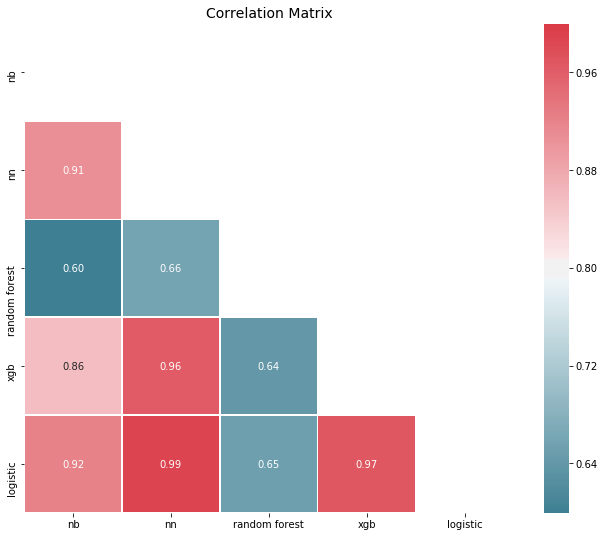

In [26]:
from mlens.visualization import corrmat
corrmat(P_test.corr(), inflate=False)
plt.show()

The chart above presents a correlation between models. As we could predict neural network and logistic regression predicts basically the same values. Other models are also highly correlated except random forest. We can clearly see that random forest gives different predictions than others. In next step, I will use only XGBoost model, which was the best and random forest because other are highly correlated with XGBoost model. 

random forest... done
xgb... done
Done.



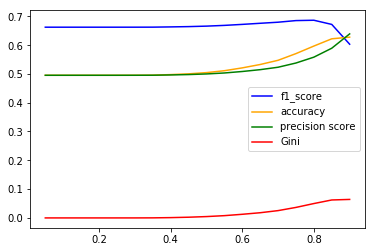

Best Gini: 6.38%


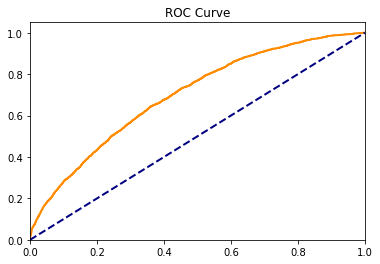

[[ 1843   962]
 [21215 34857]]
Accuracy: 62.33% (test)
Precision: 7.99%
Gini: 14.28%


In [27]:
models = {
          'random forest': {'model':rf,'cutoff':0.7},
          'xgb': {'model':xgb,'cutoff':0.8}
          }

P_val,P_test,Y_hat = predict(models,X_val,X_test)
P_test.head()

new_probs = P_val.mean(axis=1)
model_score(new_probs,y_val)
new_probs = P_test.mean(axis=1)
roc_curve(new_probs,y_test,0.6)

The simple ensemble of those two models does not improve quality of predictions. Therefore I amforced to decide that I cannot build good enough model using this data. I am sure it is possible to build such model using all the data that Lending Club has, but not using this dataset. There are many problems with this dataset and the easiest solution is to correctly calculated variables. In data science quality of the models depends mostly on data quality. 

# Things to do in real life project. 

There are few things, which I would have done differently. I decided not to do them because it would not help in the situation where there is no correctly calculated dataset.

1. Probably in real life, there should be multiple models for different products, so I would build separate models for each credit purpose.
2. My project is only analysis of the data and attempts to build predictive models. In real life, the pipeline should be built.
3. In credit scoring, it is crucial to keep models interpretable so the business owner can explain why a customer hasn't got his loan. Therefore two things should be done: analysis of sings of coefficients (it is important that signs make business sense), implementation of LIME for other models. LIME is an example of a library, which helps to understand why complex models return a specific value.